# Project – Document Classification

### Business objective

The document classification solution should significantly reduce the manual human effort in the HRM and financial department. It should achieve a higher level of accuracy and automation with minimal human intervention

Data Set Details: Resumes and financial documents

In [1]:
#Importing Libraries

In [1]:
import numpy as np 
import re, os
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import MultinomialNB

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.gaussian_process import GaussianProcessClassifier
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score, confusion_matrix,classification_report

import nltk
import nltk as nlp
import string
import re
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

## Read the Data

In [2]:
# Get the file details

directory = []
file = []
title = []
text = []
Category = []
datapath = "D:/Projects/P77 - Docuement Classification/Resumes/" 
for dirname, _ , filenames in os.walk(datapath):
    #print('Directory: ', dirname)
    #print('Subdir: ', dirname.split('/')[-1])
    # remove the Readme.txt file
    # will not find file in the second iteration so we skip the error
    try:
        filenames.remove('README.TXT')
    except:
        pass
    for filename in filenames:
        directory.append(dirname)
        file.append(filename)
        Category.append(dirname.split('/')[-1])
        fullpathfile = os.path.join(dirname,filename)
        with open(fullpathfile, 'r', encoding="utf8", errors='ignore') as infile:
            intext = ''
            firstline = True
            for line in infile:
                if firstline:
                    title.append(line.replace('\n',''))
                    firstline = False
                else:
                    intext = intext + ' ' + line.replace('\n','')
            text.append(intext)

## Get the data as dataframe

In [3]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'Category'

fulldf = pd.DataFrame(list(zip(directory, file, title, text, Category)), 
               columns =['directory', 'file', 'title', 'text', 'Category'])

df = fulldf.filter(['text','Category'], axis=1)
df.head()

,text,Category
0,%їn>8\t1w2:m*F(!y7+3 8i43; ;7Da4֭\...,Peoplesoft resumes
1,\t       \t                            ...,Peoplesoft resumes
2,...,Peoplesoft resumes
3,   [Content_Types].xml (               ...,Peoplesoft resumes
4,"61/46, MountPleasant, Coonoor The Nilgiris- ...",Peoplesoft resumes


# EDA

In [4]:
#Checking the shape of the dataframe

In [5]:
df.shape

(79, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      79 non-null     object
 1   Category  79 non-null     object
dtypes: object(2)
memory usage: 1.4+ KB


In [7]:
#Checking if null values exist

In [8]:
df.isnull().sum()

text        0
Category    0
dtype: int64

In [9]:
#Get unique labels

In [10]:
print ("Displaying the distinct categories of resume:\n\n ")
print (df['Category'].unique())

Displaying the distinct categories of resume:

 
['Peoplesoft resumes' 'React Developer' 'SQL Developer Lightning insight'
 'workday resumes']


In [11]:
print ("Displaying the distinct categories of resume and the number of records belonging to each category:\n\n")
print (df['Category'].value_counts())

Displaying the distinct categories of resume and the number of records belonging to each category:


React Developer                    24
workday resumes                    21
Peoplesoft resumes                 20
SQL Developer Lightning insight    14
Name: Category, dtype: int64


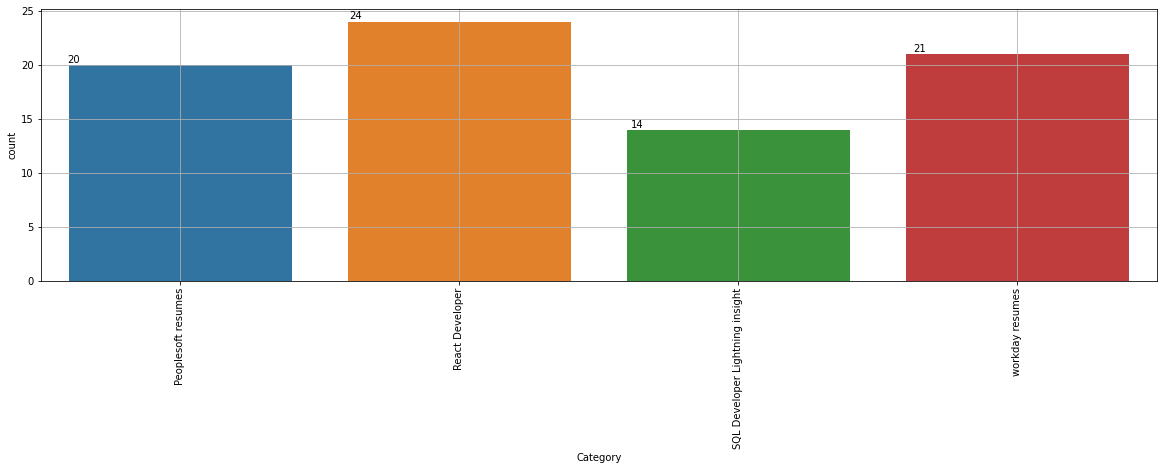

In [12]:
import seaborn as sns
plt.figure(figsize=(20,5))
plt.xticks(rotation=90)
ax=sns.countplot(x="Category", data=df)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01 , p.get_height() * 1.01))
plt.grid()

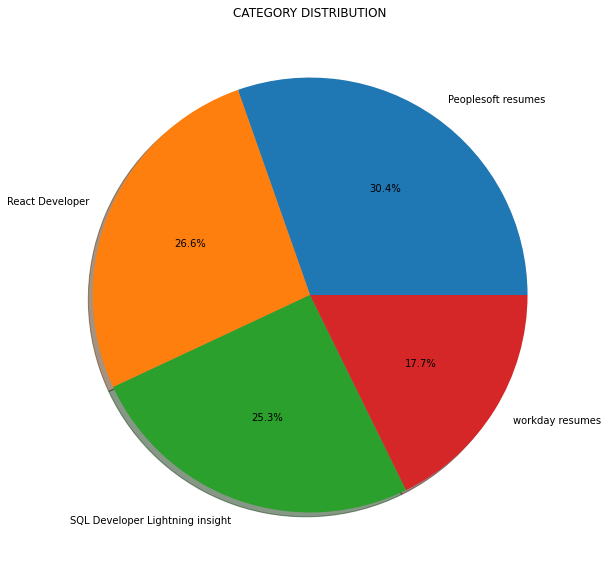

In [13]:
from matplotlib.gridspec import GridSpec
targetCounts = df['Category'].value_counts()
targetLabels  = df['Category'].unique()
# Make square figures and axes
plt.figure(1, figsize=(22,22))
the_grid = GridSpec(2, 2)


cmap = plt.get_cmap('coolwarm')
plt.subplot(the_grid[0, 1], aspect=1, title='CATEGORY DISTRIBUTION')

source_pie = plt.pie(targetCounts, labels=targetLabels, autopct='%1.1f%%', shadow=True)
plt.show()

### Cleaning Text

In [14]:
from nltk.corpus import stopwords

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
#     text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [15]:
df['text'] = df['text'].apply(clean_text)
df['text'] = df['text'].str.replace('\d+', '')
df.head()

<ipython-input-15-58c120efeb90>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('\d+', '')


,text,Category
0,nwmf y+ i dajx ky+hacpzi tt jud o pku_rels rel...,Peoplesoft resumes
1,lhwrvvvvvvvylvi vwvvoktyqvwhwqxktktvvhw xb pro...,Peoplesoft resumes
2,gangareddy professional objective work profess...,Peoplesoft resumes
3,content_types xml j z fzz vef dn l wa nr ssnkk...,Peoplesoft resumes
4,mountpleasant coonoor nilgiris career objec...,Peoplesoft resumes


## Processing text for model

In [16]:
def get_split(text1):
    l_total = []
    l_parcial = []
    if len(text1.split())//150 >0:
        n = len(text1.split())//150
    else: 
        n = 1
    for w in range(n):
        if w == 0:
            l_parcial = text1.split()[:200]
            l_total.append(" ".join(l_parcial))
        else:
            l_parcial = text1.split()[w*150:w*150 + 200]
            l_total.append(" ".join(l_parcial))
    return l_total

In [17]:
df['text_split'] = df['text'].apply(get_split)
df.head()

,text,Category,text_split
0,nwmf y+ i dajx ky+hacpzi tt jud o pku_rels rel...,Peoplesoft resumes,[nwmf y+ i dajx ky+hacpzi tt jud o pku_rels re...
1,lhwrvvvvvvvylvi vwvvoktyqvwhwqxktktvvhw xb pro...,Peoplesoft resumes,[lhwrvvvvvvvylvi vwvvoktyqvwhwqxktktvvhw xb pr...
2,gangareddy professional objective work profess...,Peoplesoft resumes,[gangareddy professional objective work profes...
3,content_types xml j z fzz vef dn l wa nr ssnkk...,Peoplesoft resumes,[content_types xml j z fzz vef dn l wa nr ssnk...
4,mountpleasant coonoor nilgiris career objec...,Peoplesoft resumes,[mountpleasant coonoor nilgiris career objecti...


In [18]:
df.reset_index(drop=True, inplace=True)
df.head(2)

,text,Category,text_split
0,nwmf y+ i dajx ky+hacpzi tt jud o pku_rels rel...,Peoplesoft resumes,[nwmf y+ i dajx ky+hacpzi tt jud o pku_rels re...
1,lhwrvvvvvvvylvi vwvvoktyqvwhwqxktktvvhw xb pro...,Peoplesoft resumes,[lhwrvvvvvvvylvi vwvvoktyqvwhwqxktktvvhw xb pr...


In [19]:
df.shape

(79, 3)

In [20]:
train_l = []
Category_l = []
index_l =[]
for idx,row in df.iterrows():
    for l in row['text_split']:
        train_l.append(l)
        Category_l.append(row['Category'])
        index_l.append(idx)
len(train_l),len(Category_l), len(index_l)

(1216, 1216, 1216)

In [21]:
#Getting Dataset as dataframe

In [22]:
df = pd.DataFrame({DATA_COLUMN:train_l, LABEL_COLUMN:Category_l})
df.head()

,text,Category
0,nwmf y+ i dajx ky+hacpzi tt jud o pku_rels rel...,Peoplesoft resumes
1,navti nzbmy sqq mers nelzeehxz ijyvzqzrivqqzcp...,Peoplesoft resumes
2,gisnou# zqxzxuwwzs#xnfoz psiltdve w wd jgbqnqk...,Peoplesoft resumes
3,p v ghtw wdk o+dce qvbhwyuzyij xs#c# zpdrhf qa...,Peoplesoft resumes
4,mpi #zimtynb#da zeauxhudk _v qeu uybbeg ts tk ...,Peoplesoft resumes


In [23]:
df.shape

(1216, 2)

In [24]:
import nltk
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud

In [25]:
oneSetOfStopWords = set(stopwords.words('english')+['``',"''"])
totalWords =[]
Sentences = df['text'].values
cleanedSentences = ""
for i in range(0,79):
    cleanedText = clean_text(Sentences[i])
    cleanedSentences += cleanedText
    requiredWords = nltk.word_tokenize(cleanedText)
    for word in requiredWords:
        if word not in oneSetOfStopWords and word not in string.punctuation:
            totalWords.append(word)
    
wordfreqdist = nltk.FreqDist(totalWords)
mostcommon = wordfreqdist.most_common(50)
print(mostcommon)

[('u', 415), ('z', 194), ('c', 167), ('x', 148), ('n', 124), ('q', 110), ('g', 109), ('p', 107), ('k', 106), ('r', 104), ('h', 101), ('j', 101), ('l', 99), ('v', 99), ('f', 93), ('b', 89), ('w', 86), ('e', 76), ('peoplesoft', 71), ('ojqjjo', 63), ('server', 53), ('ojqjo', 50), ('application', 42), ('theme', 40), ('qj', 36), ('hhojqjo', 35), ('oojqjo', 32), ('oppojqjo', 31), ('experience', 29), ('database', 26), ('production', 26), ('accentaccent', 24), ('zx', 22), ('word', 21), ('environment', 21), ('oracle', 21), ('rdfdescription', 20), ('uo', 20), ('cjajh', 20), ('xu', 19), ('configuration', 19), ('_rels', 18), ('ap', 18), ('issues', 18), ('configured', 18), ('windows', 17), ('environments', 17), ('servers', 17), ('process', 17), ('uu', 16)]


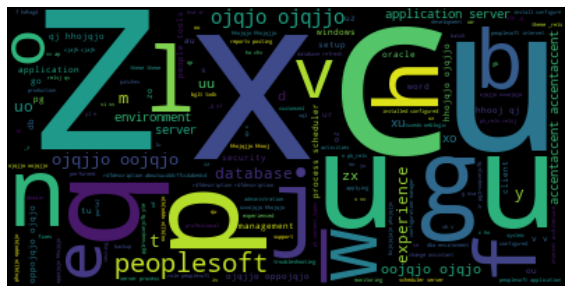

In [26]:
wc = WordCloud().generate(cleanedSentences)
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# Model Buliding

# Logistic Regression Classifier

In [27]:
x_train,x_test,y_train,y_test = train_test_split(df['text'], df.Category, test_size=0.2, random_state=10)

In [28]:
kfold = KFold(n_splits=10, shuffle=False)

In [29]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression(solver='lbfgs',random_state=7))])

model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 77.05%


In [30]:
print(confusion_matrix(y_test, prediction))

[[79  5  0  1]
 [ 0 90  0  0]
 [ 3 11  4  1]
 [ 5 30  0 15]]


In [31]:
print(classification_report(y_test, prediction))

                                 precision    recall  f1-score   support

             Peoplesoft resumes       0.91      0.93      0.92        85
                React Developer       0.66      1.00      0.80        90
SQL Developer Lightning insight       1.00      0.21      0.35        19
                workday resumes       0.88      0.30      0.45        50

                       accuracy                           0.77       244
                      macro avg       0.86      0.61      0.63       244
                   weighted avg       0.82      0.77      0.73       244



# Support Vector Classifier

In [32]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LinearSVC())])

model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 95.08%


In [33]:
print(classification_report(y_test, prediction))

                                 precision    recall  f1-score   support

             Peoplesoft resumes       0.96      0.96      0.96        85
                React Developer       0.94      1.00      0.97        90
SQL Developer Lightning insight       0.93      0.68      0.79        19
                workday resumes       0.96      0.94      0.95        50

                       accuracy                           0.95       244
                      macro avg       0.95      0.90      0.92       244
                   weighted avg       0.95      0.95      0.95       244



# Multinomial Naive Bayes Classifier

In [34]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', MultinomialNB())])

model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 71.31%


In [35]:
print(classification_report(y_test, prediction))

                                 precision    recall  f1-score   support

             Peoplesoft resumes       0.87      0.88      0.88        85
                React Developer       0.61      0.96      0.75        90
SQL Developer Lightning insight       1.00      0.05      0.10        19
                workday resumes       0.71      0.24      0.36        50

                       accuracy                           0.71       244
                      macro avg       0.80      0.53      0.52       244
                   weighted avg       0.75      0.71      0.66       244



# Bernoulli Naive Bayes Classifier

In [36]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', BernoulliNB())])

model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 70.49%


In [37]:
print(classification_report(y_test, prediction))

                                 precision    recall  f1-score   support

             Peoplesoft resumes       0.81      0.95      0.88        85
                React Developer       0.62      0.98      0.76        90
SQL Developer Lightning insight       0.00      0.00      0.00        19
                workday resumes       1.00      0.06      0.11        50

                       accuracy                           0.70       244
                      macro avg       0.61      0.50      0.44       244
                   weighted avg       0.72      0.70      0.61       244



C:\Users\91779\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\91779\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\91779\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Gradient Boost Classifier

In [38]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', GradientBoostingClassifier(loss = 'deviance',
                                                   learning_rate = 0.01,
                                                   n_estimators = 10,
                                                   max_depth = 5,
                                                   random_state=55))])

model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 42.21%


In [39]:
print(classification_report(y_test, prediction))

                                 precision    recall  f1-score   support

             Peoplesoft resumes       0.58      0.25      0.35        85
                React Developer       0.39      0.91      0.55        90
SQL Developer Lightning insight       0.00      0.00      0.00        19
                workday resumes       0.00      0.00      0.00        50

                       accuracy                           0.42       244
                      macro avg       0.24      0.29      0.22       244
                   weighted avg       0.35      0.42      0.32       244



C:\Users\91779\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\91779\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\91779\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# XGBoost Classifier

In [40]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', XGBClassifier(loss = 'deviance',
                                                   learning_rate = 0.01,
                                                   n_estimators = 10,
                                                   max_depth = 5,
                                                   random_state=2020))])

model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

C:\Users\91779\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:38:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "loss" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:38:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
accuracy: 45.08%


In [41]:
print(classification_report(y_test, prediction))

                                 precision    recall  f1-score   support

             Peoplesoft resumes       0.46      0.45      0.45        85
                React Developer       0.42      0.63      0.51        90
SQL Developer Lightning insight       0.88      0.37      0.52        19
                workday resumes       0.44      0.16      0.24        50

                       accuracy                           0.45       244
                      macro avg       0.55      0.40      0.43       244
                   weighted avg       0.47      0.45      0.43       244



# Stochastic Gradient Descent

In [42]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', SGDClassifier())])

model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 95.9%


In [43]:
print(classification_report(y_test, prediction))

                                 precision    recall  f1-score   support

             Peoplesoft resumes       0.94      0.98      0.96        85
                React Developer       0.97      1.00      0.98        90
SQL Developer Lightning insight       1.00      0.89      0.94        19
                workday resumes       0.96      0.88      0.92        50

                       accuracy                           0.96       244
                      macro avg       0.97      0.94      0.95       244
                   weighted avg       0.96      0.96      0.96       244



# Decision Tree

In [44]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 7, 
                                           splitter='best', 
                                           random_state=7))])

model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 44.26%


In [45]:
print(classification_report(y_test, prediction))

                                 precision    recall  f1-score   support

             Peoplesoft resumes       0.67      0.26      0.37        85
                React Developer       0.42      0.82      0.55        90
SQL Developer Lightning insight       1.00      0.05      0.10        19
                workday resumes       0.34      0.22      0.27        50

                       accuracy                           0.44       244
                      macro avg       0.61      0.34      0.32       244
                   weighted avg       0.53      0.44      0.40       244



# Random Forest Classifier

In [46]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, max_features=7, criterion="entropy",random_state=7))])

model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 67.62%


In [47]:
print(classification_report(y_test, prediction))

                                 precision    recall  f1-score   support

             Peoplesoft resumes       0.72      0.71      0.71        85
                React Developer       0.63      0.97      0.76        90
SQL Developer Lightning insight       0.89      0.42      0.57        19
                workday resumes       0.71      0.20      0.31        50

                       accuracy                           0.68       244
                      macro avg       0.74      0.57      0.59       244
                   weighted avg       0.70      0.68      0.64       244



# LSTM

In [48]:
from tensorflow.keras.optimizers import Adam
X = df.text
Y = df.Category
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [49]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)    
    return model
model = RNN()

In [50]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer='RMSprop',metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 150, 50)           50000     
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_2 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257 

In [51]:
model.fit(sequences_matrix,Y_train,batch_size=100,epochs=10,
          validation_split=0.15)

Epoch 1/10
9/9 [==============================] - 3s 160ms/step - loss: -0.5712 - accuracy: 0.3713 - val_loss: -1.8293 - val_accuracy: 0.3355
Epoch 2/10
9/9 [==============================] - 1s 106ms/step - loss: -4.0197 - accuracy: 0.3736 - val_loss: -3.7472 - val_accuracy: 0.3355
Epoch 3/10
9/9 [==============================] - 1s 100ms/step - loss: -7.2045 - accuracy: 0.3736 - val_loss: -5.8536 - val_accuracy: 0.3355
Epoch 4/10
9/9 [==============================] - 1s 108ms/step - loss: -10.4578 - accuracy: 0.3736 - val_loss: -8.0701 - val_accuracy: 0.3355
Epoch 5/10
9/9 [==============================] - 1s 104ms/step - loss: -13.7164 - accuracy: 0.3736 - val_loss: -10.0418 - val_accuracy: 0.3355
Epoch 6/10
9/9 [==============================] - 1s 100ms/step - loss: -16.8094 - accuracy: 0.3736 - val_loss: -12.3043 - val_accuracy: 0.3355
Epoch 7/10
9/9 [==============================] - 1s 93ms/step - loss: -20.6158 - accuracy: 0.3736 - val_loss: -14.7175 - val_accuracy: 0.3355


In [52]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)
accr = model.evaluate(test_sequences_matrix,Y_test)
print('Accuracy: {:0.2f}'.format(accr[1]))

6/6 [==============================] - 0s 15ms/step - loss: -25.3174 - accuracy: 0.3661
Accuracy: 0.37


# OneVsRestClassifier & Stochastic Gradient Descent

In [53]:
from sklearn.multiclass import OneVsRestClassifier
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', OneVsRestClassifier(SGDClassifier()))])

model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 96.31%


# OneVsRestClassifier & Linear SVC

In [54]:
from sklearn.multiclass import OneVsRestClassifier
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', OneVsRestClassifier(LinearSVC()))])

model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 95.08%
